<img src='https://i.imgur.com/Rk5wkBQ.png'>

<img src='https://vinija.ai/models/assets/transformers/5.png'>


출처 : https://vinija.ai/models/Transformers/

## Transformer의 기본 개념을 코드를 통해 이해해보자!

- Step 0 : 준비하기

In [ ]:
import tensorflow as tf
import numpy as np
import math

- step 1 : Postional Encoding

In [ ]:
#위치 인코딩 함수 정의
def get_angles(pos,i,d_model):
    #위치별로 주기를 다르게 해서 고유한 값을 생성.
    angle_rates = 1 / np.power(10000, ((2*i//2)) / np.float32(d_model))
    return pos*angle_rates
# pos : 위치 정보(1,2,...max_position), i : 임베딩 벡터의 각 차원 인덱스(0,1,2, ...d_model-1)
# angle_rates : 위치별로 각 차원마다 주기적인 값을 생성하는 비율
# -> 모든 단어 위치(pos)와 모든 임베딩 차원(i) 쌍에 대해, 위치 각도를 계산한다.
def positional_encoding(position, d_model):
    #position : 최대 문장 길이 / d_model : 임베딩 차원 수
    angle_rads = get_angles(np.arange(position)[:,np.newaxis], #각 단어의 위치
                            np.arange(d_model)[np.newaxis,:], #각 임베딩 차원을 벡터로 표현
                            d_model) #(position, d_model) -> shape이 확장.
    #짝수 인덱스에는 sin, 홀수 인덱스는 cos 함수 적용.
    angle_rads[:,0::2] = np.sin(angle_rads[:,0::2]) #even
    angle_rads[:,1::2] = np.cos(angle_rads[:,1::2]) #odd

    pos_encoding = angle_rads[np.newaxis,...] #(1,postion, d_model)
    #차원을 늘리는 이유 : Transformer에서는 batch단위로 학습을 진행하기 때문에
    # shape이 (1,postion, d_model)이 되어야함.
    return tf.cast(pos_encoding, dtype=tf.float32)

np.arange(position)[:,newaxis]

In [ ]:
#ex) position=4
np.arange(4)[:,np.newaxis]

array([[0],
       [1],
       [2],
       [3]])

In [ ]:
np.arange(4)[np.newaxis,:]

array([[0, 1, 2, 3]])

2. Scale Dot-Product Attention

In [ ]:
def scaled_dot_product_attention(Q,K,V,mask=None):
    # Q: Query(batch, num_heads, seq_len_q,depth)
    # K: Key(batch, num_heads, seq_len_k,depth)
    # V: Value(batch, num_heads, seq_len_v,depth_v)
    # 이 함수는 Query(Q), Key(K),Value(V)를 받아서 어떤 단어가 얼마나 집중(attend)해야 하는지 계산.
    matmul_qk = tf.matmul(Q,K,transpose_b=True) #Q와 K의 내적(유사도 계산)
    # Q(Query)는 어떤 단어가 질문을 던짐.
    # K(Key)는 모든 단어들이 대답 후보가 됨.
    # Q와 K의 내적 => 단어 간 유사도(친밀도, 중요도)
    # matmul_qk.shape => (batch, heads, seq_len_q, seq_len_k) => 각 query 단어가 모든 Key에 얼마나 주목하는지


    #차원 수를 루트로 나누어 정규화(안정성)
    # dot product는 depth 차원 수가 클수록, 값이 커질 가능성이 있기 때문에 정규화를 진행함.
    dk = tf.cast(tf.shape(K)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    #마스킹 적용(ex) decoder에서 future 단어 가림.(masking future words)
    # ex) I am fine -> <sos>(시작 토큰 주고) -> I 예측
    # I주고 am 예측 / am 주고 fine 예측 / decoder는 한 글자씩 예측을 함.
    # Transformer는 Decoder에서 self-attention을 진행할 때 Look-ahead Masking(미래 단어 가리기)를 함.
    if mask is not None:
        scaled_attention_logits += (mask * -1e-9 ) #매우 작은 값으로 가려 softmax에서 0이 되게함.

    # 소프트맥스로 가중치 계산
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # 가중치를 V를 곱해서 최종 출력
    output = tf.matmul(attention_weights, V)

    return output, attention_weights


3. Multi-Head Attention Layer

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0 #머리 수는 d_model로 나누어 떨어져야 함.

        self.num_heads = num_heads
        self.depth = d_model // num_heads

        # Query, Key, Value를 위한 Dense layer(선형 변환용)
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self,x,batch_size):
        # x : (batch_size, seq_len, d_model)
        # =>  (batch_size, num_heads,seq_len, depth)
        # 하나의 Attention을 하는게 아니라, 여러 개의 "시선을 나눠서 동시에" Attention을 수행;.

        x = tf.reshape(x,(batch_size, -1, self.num_heads, self.depth))
        # ex) d_model = 512, num_heads=8 -> depth=64
        # x.shape => (32,20,512) -> 32개의 문장(batch), 각 문장 20단어, 512차원 임베딩
        # -> head가 뒤에 위치하게 됨. (batch, seq_len, num_heads, depth)
        return tf.transpose(x, perm=[0,2,1,3])
        # (batch_size, num_heads, seq_len,depth) -> 이 구조가 있어야 각 head별로 attetnion 연산을 쉽게 할 수 있다.

    def call(self,v,k,q, mask=None):
        batch_size = tf.shape(q)[0]

        #Q,K,V 생성
        Q = self.W_q(q) #(batch_size, seq_len_q,d_model)
        K = self.W_k(k) #(batch_size, seq_len_k,d_model)
        V = self.W_v(v) #(batch_size, seq_len_v,d_model)

        # Q,K,V 생성 후 heads로 나누기
        Q = self.split_heads(Q,batch_size)
        K = self.split_heads(K,batch_size)
        V = self.split_heads(V,batch_size)

        #scaled Dot Product Attention 적용
        scaled_attention, attention_weights  = scaled_dot_product_attention(Q,K,V,mask)

        #head들을 다시 concat(transpose block ->reshape)
        scaled_attention = tf.transpose(scaled_attention,perm=[0,2,1,3]) #(batch, seq_len,heads,depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.num_heads *self.depth))

        #최종 출력
        output = self.dense(concat_attention)
        return output, attention_weights
        #attention_weights : 어떤 단어에 집중내는 값.

4. Transformer Block(Encoder에서 사용)

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff,activation='relu'), #확장
        tf.keras.layers.Dense(d_model)
    ])

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self,d_model, num_heads, dff, rate=0.1):
        super().__init__()

        self.mha= MultiHeadAttention(d_model, num_heads) #Multi-head Attention
        self.ffn = point_wise_feed_forward_network(d_model,dff) #Feed-forword network

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    def call(self,x,training,mask=None):
        #1.self-attention 수행
        attn_output, attn_weights = self.mha(x,x,x,mask) #(batch, seq_len,d_model)
        attn_output = self.dropout1(attn_output, training = training)
        out1 = self.layernorm1(x+attn_output) #잔차 연결+ 정규화

        #2. Feed-forward Network 수행
        ffn_output = self.ffn(out1) # (batch, seq_len,d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1+ffn_output)
        return out2,attn_weights

시각화 함수 만들기(Head별 Attention Map)

In [ ]:
sample_input = tf.random.uniform((1, 10, 512))
mha = MultiHeadAttention(d_model=512, num_heads=8)
output, attention_weights = mha(sample_input, sample_input, sample_input)

print(output.shape)        # (1, 10, 512)
print(attention_weights.shape)  # (1, 8, 10, 10)

(1, 10, 512)
(1, 8, 10, 10)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_attention_map(attn_weights, head=0):
    # atten_weights : (bacth,heads, seq_len, seq_len)
    # head : 보고 싶은 attention head index
    atten = attn_weights[0][head]
    plt.figure(figsize=(6,5))
    plt.title(f'Attention Map - Head {head}')
    plt.imshow(atten, cmap='viridis')
    plt.xlabel('Key 위치')
    plt.ylabel('Query 위치')
    plt.colorbar()
    plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


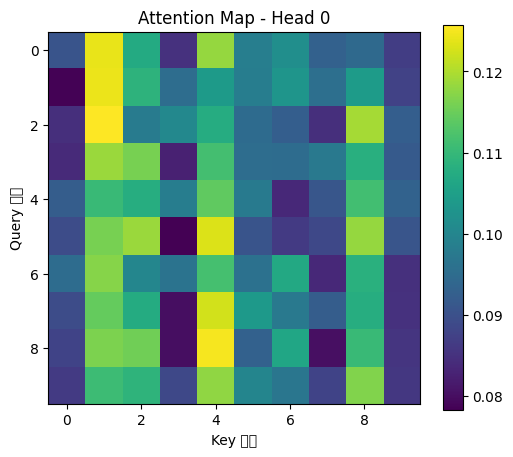

In [ ]:
show_attention_map(attention_weights.numpy(), head=0)

여러 head 함수 보기

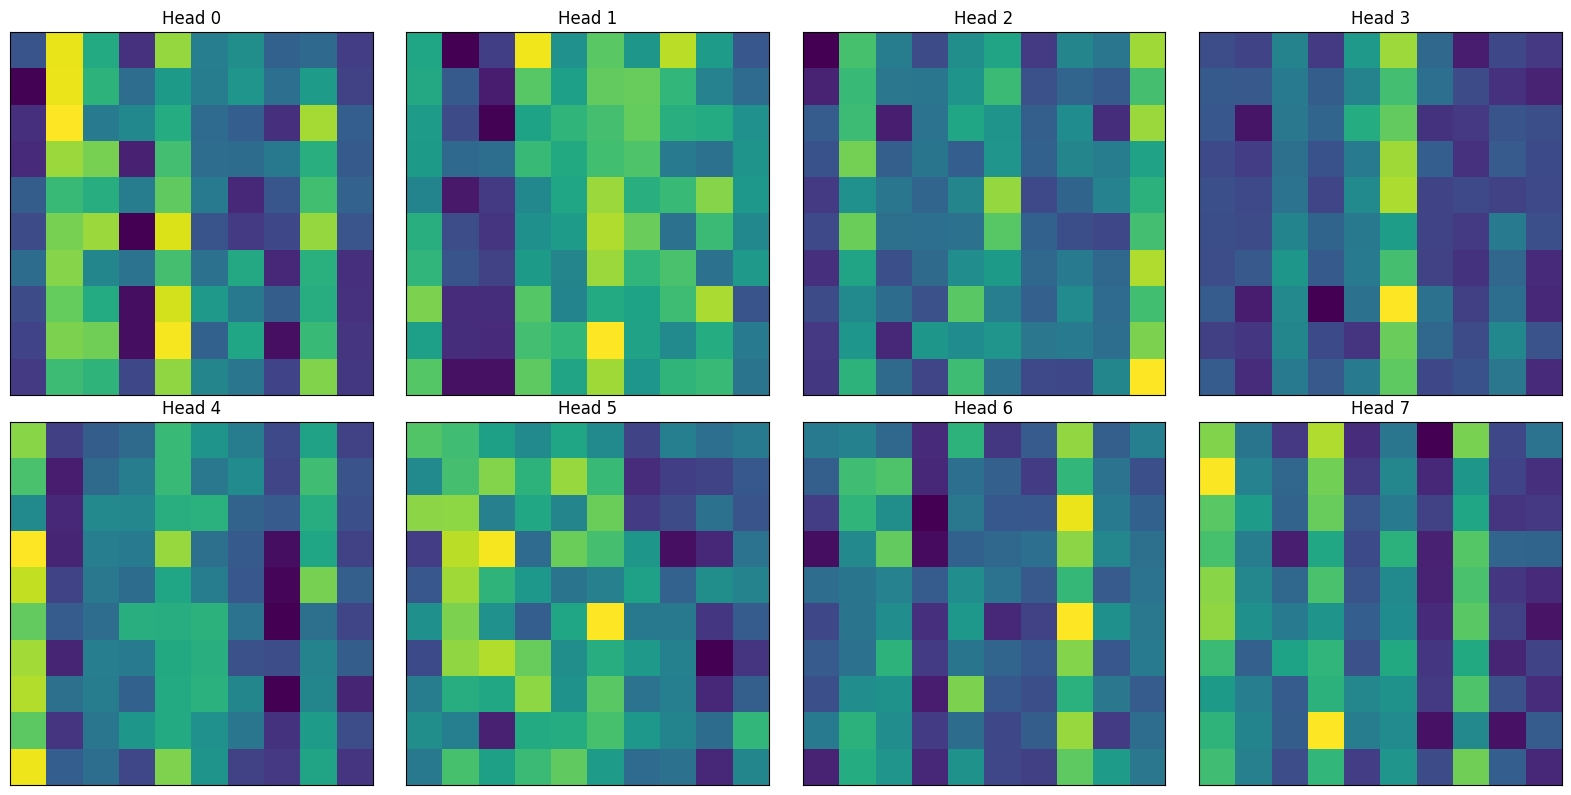

In [ ]:
def show_all_heads(attn_weights):
    num_heads = attn_weights.shape[1]
    plt.figure(figsize=(16, 8))
    for i in range(num_heads):
        plt.subplot(2, num_heads//2, i+1)
        plt.imshow(attn_weights[0][i], cmap='viridis')
        plt.title(f"Head {i}")
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

# 실행
show_all_heads(attention_weights.numpy())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
tf.__version__

'2.13.0'

### 포지셔널 인코딩

$$ P E_{(pos,2i)} = sin(pos/10000^{2i/d_{model}}) $$
$$ P E_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model}}) $$

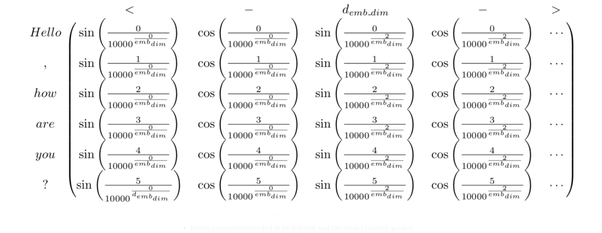

In [ ]:
# 최종 버전
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], # 0 ~ d_model
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines

    pos_encoding = tf.constant(angle_rads)
    print(pos_encoding.shape)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 128)
sample_pos_encoding.pos_encoding.numpy()


(50, 128)
(1, 50, 128)


array([[[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 8.41471016e-01,  5.40302277e-01,  7.61720419e-01, ...,
          1.00000000e+00,  1.15478222e-04,  1.00000000e+00],
        [ 9.09297466e-01, -4.16146815e-01,  9.87046242e-01, ...,
          9.99999940e-01,  2.30956444e-04,  1.00000000e+00],
        ...,
        [ 1.23573124e-01, -9.92335498e-01,  1.39922664e-01, ...,
          9.99980330e-01,  5.42744994e-03,  9.99985278e-01],
        [-7.68254697e-01, -6.40144348e-01, -6.63569212e-01, ...,
          9.99979496e-01,  5.54292602e-03,  9.99984622e-01],
        [-9.53752637e-01,  3.00592542e-01, -9.99784708e-01, ...,
          9.99978662e-01,  5.65840257e-03,  9.99983966e-01]]],
      dtype=float32)

### Scaled Dot-Production Attention

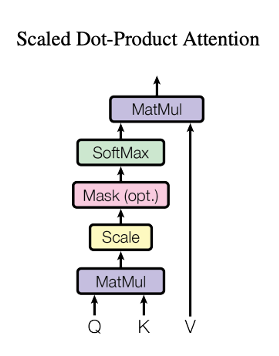

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

### MultiHeadAttention

멀티 헤드 어텐션에서는 크게 두 종류의 가중치 행렬이 나왔습니다. Q, K, V 행렬을 만들기 위한 가중치 행렬인 WQ, WK, WV 행렬과 바로 어텐션 헤드들을 연결(concatenation) 후에 곱해주는 WO 행렬입니다.

멀티 헤드 어텐션의 구현은 크게 다섯 가지 파트로 구성됩니다.

1. WQ, WK, WV에 해당하는 d_model 크기의 밀집층(Dense layer)을 지나게한다.
2. 지정된 헤드 수(num_heads)만큼 나눈다(split).
3. 스케일드 닷 프로덕트 어텐션.
4. 나눠졌던 헤드들을 연결(concatenatetion)한다.
5. WO에 해당하는 밀집층을 지나게 한다.


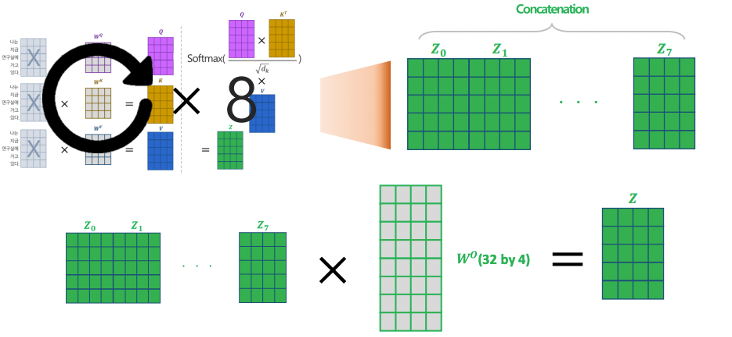

[참고] python assert    
assert는 "이 조건이 참일때 코드는 내가 보장한다. 이 조건은 올바르다!   
하지만 이 조건이 거짓이라는 것은 내가 보증하지 않은 동작이다. 그러니 AssertionError를 발생해라!" 라는 뜻입니다.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))

    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

입력된 정수 시퀀스에서 패딩 토큰의 인덱스인지, 아닌지를 판별하는 함수를 구현하는 것입니다. 아래의 함수는 정수 시퀀스에서 0인 경우에는 1로 변환하고, 그렇지 않은 경우에는 0으로 변환하는 함수입니다.

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
# 예시
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


### 인코더

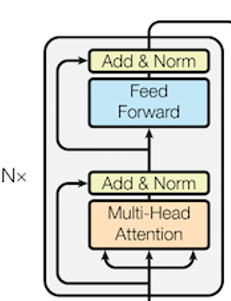

하나의 인코더 블록. 즉, 하나의 인코더 층을 구현하는 코드입니다.

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용 -> 어텐션에서 패딩 토큰 제외
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

실제로 트랜스포머는 num_layers 개수만큼의 인코더 층을 사용하므로 이를 여러번 쌓는 코드를 별도 구현합니다.

In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더

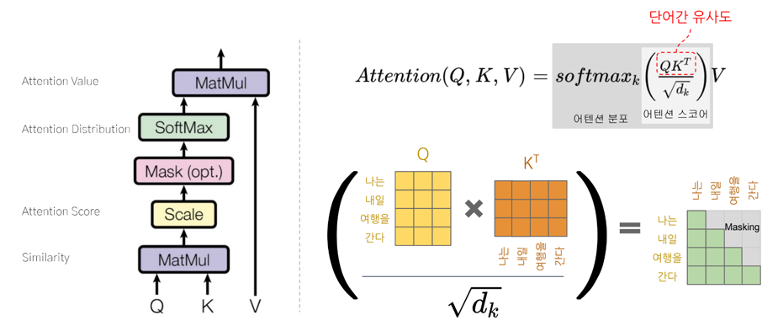

In [ ]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) #  Lower triangular part.
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))


tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


임의의 정수 시퀀스 입력을 넣어서 결과를 봅시다. 패딩 마스크를 테스트 하기위해 세번째 위치에 정수 0을 넣었습니다. 룩-어헤드 마스크이므로 삼각형 모양의 마스킹이 형성되면서 패딩 마스크가 포함되어져 있는 세번째 열이 마스킹됩니다.

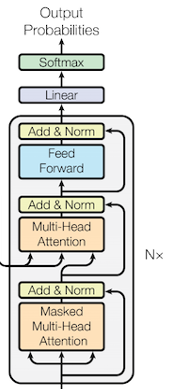

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크(룩어헤드 + 패딩)
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

포지셔널 인코딩 후 디코더 층을 num_layers의 개수만큼 쌓는 코드입니다.

In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 트랜스포머 구현하기

지금까지 구현한 인코더와 디코더 함수를 조합하여 트랜스포머를 조립할 차례입니다. 인코더의 출력은 디코더에서 인코더-디코더 어텐션에서 사용되기 위해 디코더로 전달해줍니다. 그리고 디코더의 끝단에는 다중 클래스 분류 문제를 풀 수 있도록, vocab_size 만큼의 뉴런을 가지는 출력층을 추가해줍니다.

In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

##################################################################

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

(9000, 128)
(1, 9000, 128)
(9000, 128)
(1, 9000, 128)


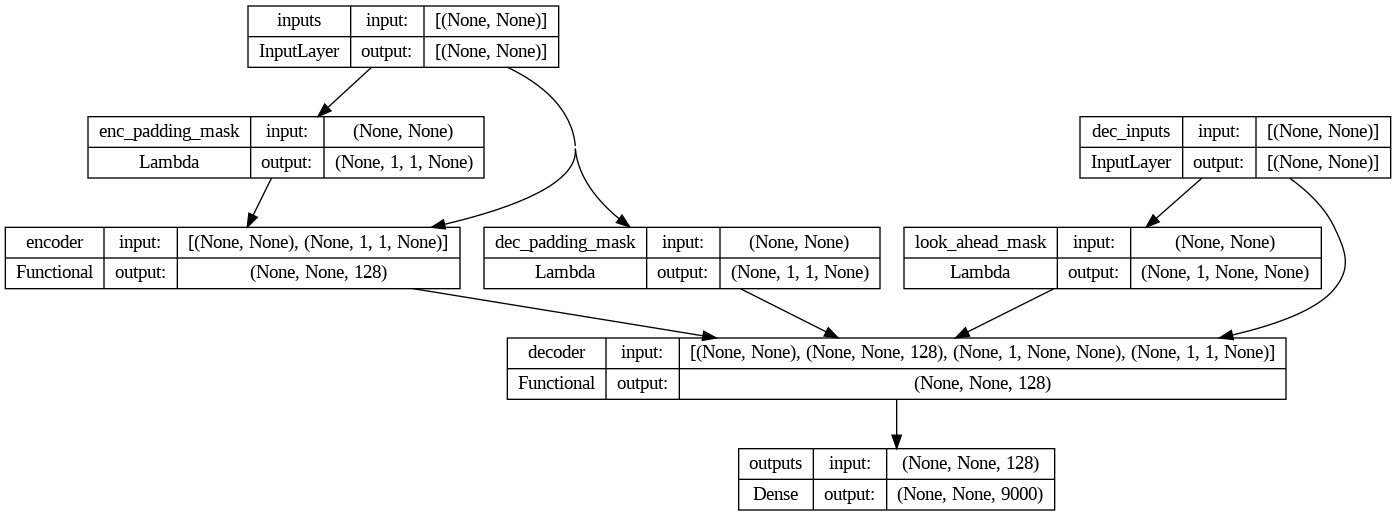

In [ ]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

In [ ]:
y_true = 1
tf.cast(tf.not_equal(y_true, 0), tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32) # y_true가 0(패딩이면) -> 0 , 1이면 -> 1
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss) #Computes the mean of elements across dimensions of a tensor.

학습률 스케줄러(Learning rate Scheduler)는 미리 학습 일정을 정해두고 그 일정에 따라 학습률이 조정되는 방법입니다. 트랜스포머의 경우 사용자가 정한 단계까지는 학습률을 증가시켰다가 단계에 이르면 학습률을 점차적으로 떨어트리는 방식을 사용합니다.

트랜스포머에서는 warmup_steps이라는 변수를 정하고 step_num이 warmup_steps보다 작을 경우는 학습률을 선형적으로 증가 시키고, step_num이 warmup_steps에 도달하게 되면 학습률을 step_num의 역제곱근에 따라서 감소시킵니다.

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

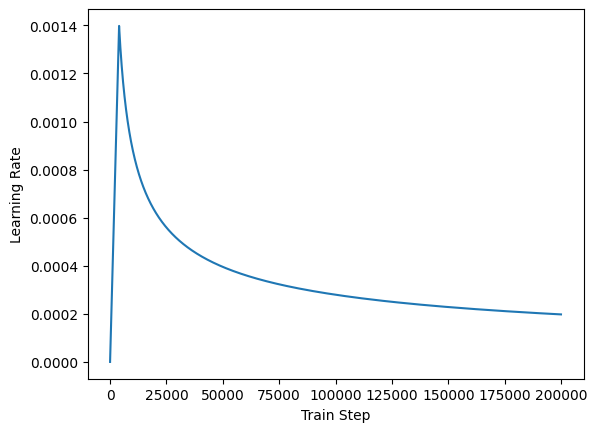

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

참고 : [언어 이해를 위한 변환기 모델](https://www.tensorflow.org/text/tutorials/transformer?hl=ko)

# 챗봇 구현

출처 : 딥러닝을 이용한 자연어 처리 입문

In [ ]:
import pandas as pd
import urllib.request
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import re

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")

train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [ ]:
print('챗봇 샘플의 개수 :', len(train_data))

챗봇 샘플의 개수 : 11823


In [ ]:
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [ ]:
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [ ]:
answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [ ]:
len(questions)

11823

In [ ]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


In [ ]:
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [5766, 611, 3509, 141, 685, 3747, 849]


In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 decode() 테스트해보기

# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5766, 611, 3509, 141, 685, 3747, 849]
기존 문장: 가스비 비싼데 감기 걸리겠어


In [ ]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5766 ----> 가스
611 ----> 비 
3509 ----> 비싼
141 ----> 데 
685 ----> 감기 
3747 ----> 걸리
849 ----> 겠어


In [ ]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_filter(questions, answers)

In [ ]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 40)
답변 데이터의 크기(shape) : (11823, 40)


In [ ]:
# 0번째 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
print('단어 집합의 크기(Vocab size): {}'.format(VOCAB_SIZE))
print('전체 샘플의 수(Number of samples): {}'.format(len(questions)))

단어 집합의 크기(Vocab size): 8180
전체 샘플의 수(Number of samples): 11823


In [ ]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(8180, 256)
(1, 8180, 256)
(8180, 256)
(1, 8180, 256)


In [ ]:
MAX_LENGTH = 40


optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 50

model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
185/185 [==============================] - 60s 193ms/step - loss: 1.0368 - accuracy: 0.0476
Epoch 2/50
185/185 [==============================] - 14s 76ms/step - loss: 0.9115 - accuracy: 0.0541
Epoch 3/50
185/185 [==============================] - 15s 81ms/step - loss: 0.8559 - accuracy: 0.0576
Epoch 4/50
185/185 [==============================] - 12s 63ms/step - loss: 0.7711 - accuracy: 0.0633
Epoch 5/50
185/185 [==============================] - 11s 60ms/step - loss: 0.6575 - accuracy: 0.0744
Epoch 6/50
185/185 [==============================] - 11s 60ms/step - loss: 0.5474 - accuracy: 0.0858
Epoch 7/50
185/185 [==============================] - 11s 61ms/step - loss: 0.4602 - accuracy: 0.0952
Epoch 8/50
185/185 [==============================] - 11s 60ms/step - loss: 0.3955 - accuracy: 0.1031
Epoch 9/50
185/185 [==============================] - 11s 61ms/step - loss: 0.3452 - accuracy: 0.1102
Epoch 10/50
185/185 [==============================] - 11s 61ms/step - loss: 0.30

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
output = predict('영화 볼래?')

Input: 영화 볼래?
Output: 필요한 사람이 될 수 있어요 .


In [ ]:
output = predict("고민이 있어")

Input: 고민이 있어
Output: 너무 길지 않나요 .


In [ ]:
output = predict("너무 화가나")

Input: 너무 화가나
Output: 그럴수록 당신이 힘들 거예요 .


In [ ]:
output = predict("게임하고싶은데 할래?")

Input: 게임하고싶은데 할래?
Output: 저 주세요 .


In [ ]:
output = predict("나 너 좋아하는 것 같아")

Input: 나 너 좋아하는 것 같아
Output: 누가 더 사랑하는지는 상관 없어요 .


In [ ]:
output = predict("딥 러닝 자연어 처리를 잘 하고 싶어")

Input: 딥 러닝 자연어 처리를 잘 하고 싶어
Output: 매일 조금씩 해보세요 .


# Bert(Bidirectional Encoder Representations from Transformers)

2018년 구글이 공개한 사전 훈련된(pre-trained) 모델.

transformer를 이용해 구현되었으며, 위키피디아(25억 단어)와 BookCorpus(8억 단어)와 같은 레이블(label)이 없는 텍스트 데이터로 훈련되었음.

Bert를 통해 레이블이 있는 다른 작업(task)에서 추가 훈련과 함께 하이퍼파라미터를 재조정하면 성능이 높게 나옴. 다른 작업에 대해 파라미터 재조정을 위한 추가 훈련 과정을 파인튜닝(fine-tuning)이라고 함.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdpWcZt%2FbtrlfzV9WtN%2F0WvwqK0SBwGygRx7HVTXz0%2Fimg.png'>
    
    출처 : 딥러닝을 이용한 자연어 처리 입문

BERT의 기본 구조는 transformer의 인코더를 쌓아올린 구조. Base 버전에선 총 12개를 쌓았으며, Large 버전에선 총 24개를 쌓았음.

- L = 인코더 층 개수
- D = $d_{model}$ 크기(인코더와 디코더 입력/출력의 크기 = 임베딩 벡터 차원)
- A = 셀프 어텐션 헤드 개수

BERT-base : L=12, D=768, A=12 -> 110M개의 파라미터

BERT-Large : L=24, D=1024, A = 16 -> 340M개의 파라미터

## BERT의 문맥을 반영한 임베딩(Contextual Embedding)

BERT의 입력은 임베딩 층(embedding layer)을 지난 임베딩 벡터. $d_model$을 768로 정의하여 모든 단어들은 768차원의 임베딩 벡터가 되어 입력에 사용. 출력 벡터 역시 모두 768차원

<center>
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdMBerM%2FbtrlbKKFDFM%2FYkvaxLkfIVg4mNZyMWyGp0%2Fimg.png'>
</center>
    출처 : 딥러닝을 이용한 자연어 처리 입문

BERT 연산을 거친 후의 출력 임베딩은 문장의 문맥을 모두 참고한 임베딩.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbL8ifU%2FbtrlfR93qY4%2Fzewdqf5vbUkKIwl0c6eZR1%2Fimg.png'>
    
    출처 : 딥러닝을 이용한 자연어 처리 입문
[CLS]란 벡터는 초기 입력일 떈 단순히 임베딩 층을 지난 임베딩 벡터였지만, BERT를 지나면 [CLS],I,love,you 라는 **모든 단어 벡터들은 참고한 문맥 정보를 가진 벡터.**

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbdUCt0%2FbtrlgTUcris%2Fkj7HevtQJIx6j7NdLgruA1%2Fimg.png'>
    
    출처 : 딥러닝을 이용한 자연어 처리 입문

하나의 단어가 모든 단어를 참고하는 연산은 BERT의 12개 층에서 전부 이루어지는 연산. BERT의 첫번째 층의 출력 임베딩은 두 번 째 층의 입력 임베딩이 됨.


BERT가 문맥을 반영한 출력 임베딩을 얻는 방식은 셀프 어텐션을 이용하는 것.


## BERT의 서브워드 토크나이저 : WordPiece

BERT는 단어보다 더 작은 단위로 쪼개는 서브워드 토크나이저(subword tokenizer)를 사용함.

subword tokenizer는 기본적으로 자주 등장하는 단어는 그대로 단어 집합에 추가하지만, 자주 등장하지 않는 단어는 더 작은 단위인 서브워드로 분리되어 서브워드들이 단어 집합에 추가 된다는 아이디어를 갖고 있음.

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
result = tokenizer.tokenize('Here is the sentence I want embeddings for.')
print(result)

['here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.']


embeddings는 단어 집합에 존재하지 않으므로 서브단위로 분리

In [ ]:
#BERT의 단어 집합에 특정 단어가 있는지 조회하려면 .vocab[]을 사용하면 됨.
print(tokenizer.vocab['here'])

2182


단어 here이 정수 인코딩을 위해 단어 집합 내부적으로 2182라는 정수로 매핑되어졌다는 의미입니다. 존재하지 않는 단어 embeddings를 조회하면 KeyError가 발생합니다.

In [ ]:
print(tokenizer.vocab['embeddings'])

KeyError: ignored

대신 em, ##bed, ##ding, ##s는 모두 단어 집합에 존재한다고 나옵니다. 그렇다면 BERT 단어 집합 전체는 총 몇 개일까요?

In [ ]:
with open('vocab.txt', 'w') as f:
    for token in tokenizer.vocab.keys():
        f.write(token + '\n')

In [ ]:
df = pd.read_fwf('vocab.txt', header=None) # read_fwf: 고정 너비 형식의 table을 DataFrame으로 읽어들이는 함수
df

,0
0,[PAD]
1,[unused0]
2,[unused1]
3,[unused2]
4,[unused3]
...,...
30517,##．
30518,##／
30519,##：
30520,##？


In [ ]:
print('단어 집합의 크기:', len(df))

단어 집합의 크기: 30522


BERT에서 사용되는 특별 토큰들과 그와 매핑되는 정수

[PAD] - 0

[UNK] - 100

[CLS] - 101

[SEP] - 102

[MASK] - 103

## 포지션 임베딩(Position Embedding)

**트랜스포머에선 포지셔널 인코딩이란 방법을 통해 단어의 위치 정보를 표현**했습니다. 사인 함수와 코사인 함수를 사용하여 위치에 따라 다른 값을 가지는 행렬을 만들어 이를 단어 벡터들과 더하는 방식이었죠. **BERT는 이와 유사하지만 학습을 통해 위치 정보를 얻는 포지션 임베딩을 사용합니다.**

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FnWtIx%2Fbtrlhya7bl3%2FDQrxkBb8lumrun63pgTVz1%2Fimg.png'>

BERT에선 문장의 최대 길이를 512로 하므로 총 512개의 포지션 임베딩 벡터가 학습됩니다. 지금까지 나온 임베딩 층을 정리하면 1) 단어 집합의 크기가 30,522개인 단어 벡터를 위한 임베딩 층과 2) 512개의 포지션 벡터를 위한 임베딩 층이 있습니다.

## BERT의 사전훈련

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fdsd1XS%2Fbtrk8PergMv%2F7Vukt3KFXwkH6MzHpUkuQK%2Fimg.png'>

    출처 :딥러닝을 이용한 자연어 처리 입문

BERT 논문에 첨부된 그림은 BERT, GPT-1, ELMo의 구조적인 차이를 보여줍니다. ELMo의 경우 정방향 LSTM과 역방향 LSTM을 각각 훈련시키는 방식으로 양방향 언어 모델을 만들었습니다. GPT-1은 트랜스포머(Trm)의 디코더를 이전 단어들로부터 다음 단어를 예측하는 방식의 단방향 언어 모델입니다. 반면, BERT는 화살표가 양방향으로 뻗어나가는 모습으로 이는 마스크드 언어 모델(Masked Language Model, MLM)을 통한 것입니다.

BERT의 사전 훈련 방법은 크게 2가지입니다. 첫 번째로 **마스크드 언어 모델**, 두 번째로 **다음 문장 예측**(Next sentence prediction, NSP)입니다.

### Masked Language Model

BERT는 사전 훈련을 위해 입력 텍스트의 15% 단어를 랜덤으로 마스킹합니다. 이후 신경망이 가려진 단어들을 예측하도록 합니다. **쉽게 말해 빈칸 뚫고 맞추기 학습입니다.**

1. 80% 단어들은 [MASK]로 변경
예) The man went to the store -> The man went to the [MASK]

2. 10% 단어들은 램덤으로 단어 변경
예) The man went to the store -> The man went to the dog

3. 10% 단어들은 동일하게 유지
예) The man went to the store -> The man went to the store

<center>
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FH8DCh%2Fbtrk8PerFjR%2Fos1nXCXxpwq2WDx8PK7hnk%2Fimg.png'>
</center>
    
    출처 :딥러닝을 이용한 자연어 처리 입문

이는 [MASK]만 사용할 경우 [MASK] 토큰이 파인튜닝 단계에선 나타나지 않기 때문에 사전 학습 단계와 파인튜닝 단계에서의 불일치 문제를 피하기 위함.

전체 단어의 12%는 [MASK]로 변경되고, 1.5%는 랜덤으로 또 다른 단어로 변경되고, 1.5%는 단어가 변경되지 않지만 BERT는 해당 단어가 원래 단어인지, 변경된 단어인지 알 수 없습니다.

예를 들어, 'My dog is cute. he likes playing'이란 문장이 있고, 서브워드 토크나이저에 의해 ['my', 'dog', 'is' 'cute', 'he', 'likes', 'play', '##ing']로 토큰화되었다고 합시다. BERT의 입력으로 사용되면서 아래처럼 변경될 수 있습니다.

<center>
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FISUIT%2FbtrlfA1XLnd%2FdWmNVo5rI0JwuOyK7BvQGK%2Fimg.png'>
</center>

    출처 :딥러닝을 이용한 자연어 처리 입문

## 다음 문장 예측

BERT는 두 개의 문장을 준 후에 이 문장이 이어지는 문장인지 아닌지를 맞추는 방식으로 훈련합니다. 이를 위해 50:50 비율로 실제 이어지는 두 개의 문장과 랜덤으로 이어붙인 두 개의 문장이 주어집니다.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbvI17L%2FbtrliMf3uSj%2FRy0UKuZxABJbyiwc0MOGG0%2Fimg.png'>

    출처 : 딥러닝을 이용한 자연어 처리 입문

BERT의 입력에선 [SEP]라는 특별 토큰을 사용해서 문장을 구분합니다. 첫 번째 문장의 끝에 [SEP] 토큰을 넣고, 두 번째 문장이 끝나면 역시 [SEP] 토큰을 붙여줍니다. 그리고 이 두 문장이 실제 이어지는 문장인지 아닌지를 [CLS] 토큰 위치의 출력층에서 이진 분류 문제를 풀도록 합니다. [CLS] 토큰은 BERT가 분류 문제를 풀기 위해 추가된 특별 토큰입니다. 또한 위의 그림처럼 마스크드 언어 모델과 다음 문장 예측은 따로 학습하는 것이 아니라 loss를 합하여 학습이 동시에 이루어집니다.

## 세그먼트 임베딩(Segment Embedding)

문장 구분을 위해 BERT는 세그먼트 임베딩이란 또 다른 임베딩 층을 사용합니다. 첫 번째 문장에는 Sentence 0 임베딩, 두 번째 문장에는 Sentence 1 임베딩을 더해주는 방식으로 임베딩 벡터는 2개만 사용됩니다.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FD5Wo6%2FbtrlgTGIXsy%2F9fh5ILgv5uVCSlp8ZUDyIK%2Fimg.png'>

결론적으로 BERT는 총 3개의 임베딩 층이 사용됩니다.

**WordPiece Embedding**
- 실질적인 입력이 되는 워드 임베딩
- 임베딩 벡터의 종류는 단어 집합의 크기로 30,522개

**Position Embedding**
- 위치 정보를 학습하기 위한 임베딩
- 임베딩 벡터의 종류는 문장의 최대 길이인 512개

**Segment Embedding**
- 두 개의 문장을 구분하기 위한 임베딩
- 임베딩 벡터의 종류는 문장의 최대 개수인 2개

# HuggingFace란?

- HuggingFace는 자연어 처리, 더 나아가 딥러닝을 위한 오픈소스 라이브러리를 제공하는 회사
- 파이썬과 PyTorch, TensorFlow를 위한 최신의 Transformer 아키텍처를 ***쉽게 사용할 수 있게 함***

- 여러 라이브러리 중 가장 유명한 Transformers 제공
    - Transforemrs : 다양한 사전 학습된 모델(Pre-Trained Model) 제공,
    - 모델 Hub로서의 역할
    - BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet 등과 같은 주요 모델들이 포함
    - 이러한 모델들은 텍스트 분류, 정보 추출, 질문 응답, 요약, 번역, 텍스트 생성 등의 NLP 작업을 수행하는 데 사용가능
    - https://huggingface.co/


### 주의!

1. 각 모델은 각 모델에 맵핑되는 토크나이저가 존재함
    - 예를 들어, A 모델을 사용한다면 A 모델의 토크나이저를 사용해야 함
    - 만약 A 모델은 단어 '커피'가 인덱스 3번이고, B모델은 단어 '커피'가 인덱스 500번이라면,
    문장 '커피를 마시고 있다'라는 문장이 들어올 경우 엉뚱한 라벨링 생성

In [ ]:
# hugging face transformers 라이브러리 설치
!pip install transformers

In [ ]:
from transformers import TFBertForMaskedLM
from transformers import AutoTokenizer

masked_model = TFBertForMaskedLM.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


# 01. BERT

BERT는 이전 챕터에서 배웠던 트랜스포머를 이용하여 구현되었으며, 위키피디아(25억 단어)와 BooksCorpus(8억 단어)와 같은 레이블이 없는 텍스트 데이터로 사전 훈련된 언어 모델입니다

BERT가 높은 성능을 얻을 수 있었던 것은, 레이블이 없는 방대한 데이터로 사전 훈련된 모델을 가지고, 레이블이 있는 다른 작업(Task)에서 추가 훈련과 함께 하이퍼파라미터를 재조정하여 이 모델을 사용하면 성능이 높게 나오는 기존의 사례들을 참고하였기 때문입니다. 다른 작업에 대해서 파라미터 재조정을 위한 추가 훈련 과정을 파인 튜닝(Fine-tuning)이라고 합니다.

### 1. Subword Tokenizer

BERT는 단어보다 더 작은 단위로 쪼개는 서브워드 토크나이저를 사용합니다. BERT가 사용한 토크나이저는 WordPiece 토크나이저를 사용하였습니다.

서브워드 토크나이저는 기본적으로 자주 등장하는 단어는 그대로 단어 집합에 추가하지만, 자주 등장하지 않는 단어의 경우에는 더 작은 단위인 서브워드로 분리되어 서브워드들이 단어 집합에 추가된다는 아이디어를 갖고있습니다. 이렇게 단어 집합이 만들어지고 나면, 이 단어 집합을 기반으로 토큰화를 수행합니다.

1. 토큰이 단어 집합에 존재한다.
    => 해당 토큰을 분리하지 않는다.

2. 토큰이 단어 집합에 존재하지 않는다.
    => 해당 토큰을 서브워드로 분리한다.
    => 해당 토큰의 첫번째 서브워드를 제외한 나머지 서브워드들은 앞에 "##"를 붙인 것을 토큰으로 한다.

In [ ]:
import pandas as pd
from transformers import BertTokenizer

# Pretrained 된 Bert-base tokenizer 다운
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
tokenizer

Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
}

In [ ]:
result = tokenizer.tokenize('Here is the sentence I want embeddings for.')
print(result)

['here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.']


embeddings라는 단어는 단어 집합에 존재하지 않으므로 em, ##bed, ##ding, #s로 분리됩니다.

In [ ]:
tokenizer.vocab['sentence']

6251

In [ ]:
tokenizer.vocab['embeddings']

KeyError: ignored

In [ ]:
# 단어 딕셔너리
print(tokenizer.vocab)
print(len(tokenizer.vocab))

OrderedDict([('[PAD]', 0), ('[unused0]', 1), ('[unused1]', 2), ('[unused2]', 3), ('[unused3]', 4), ('[unused4]', 5), ('[unused5]', 6), ('[unused6]', 7), ('[unused7]', 8), ('[unused8]', 9), ('[unused9]', 10), ('[unused10]', 11), ('[unused11]', 12), ('[unused12]', 13), ('[unused13]', 14), ('[unused14]', 15), ('[unused15]', 16), ('[unused16]', 17), ('[unused17]', 18), ('[unused18]', 19), ('[unused19]', 20), ('[unused20]', 21), ('[unused21]', 22), ('[unused22]', 23), ('[unused23]', 24), ('[unused24]', 25), ('[unused25]', 26), ('[unused26]', 27), ('[unused27]', 28), ('[unused28]', 29), ('[unused29]', 30), ('[unused30]', 31), ('[unused31]', 32), ('[unused32]', 33), ('[unused33]', 34), ('[unused34]', 35), ('[unused35]', 36), ('[unused36]', 37), ('[unused37]', 38), ('[unused38]', 39), ('[unused39]', 40), ('[unused40]', 41), ('[unused41]', 42), ('[unused42]', 43), ('[unused43]', 44), ('[unused44]', 45), ('[unused45]', 46), ('[unused46]', 47), ('[unused47]', 48), ('[unused48]', 49), ('[unused49]

In [ ]:
# 단어 조회
tokenizer.vocab['natural']

3019

In [ ]:
# embeddings를 조회해봅시다
tokenizer.vocab['embeddings']

KeyError: ignored

In [ ]:
tokenizer.tokenize('embeddings')

['em', '##bed', '##ding', '##s']

In [ ]:
tokenizer()

In [ ]:
# em, ##bed, ##ing , ##s는 모두 단어집합에 존재합니다.

tokenizer.vocab['em'], tokenizer.vocab['##bed'], tokenizer.vocab['##ing'], tokenizer.vocab['##s']

(7861, 8270, 2075, 2015)

BERT에 사용되는 토큰들의 위치

In [ ]:
print(tokenizer.vocab['[PAD]'])
print(tokenizer.vocab['[UNK]'])
print(tokenizer.vocab['[CLS]'])
print(tokenizer.vocab['[SEP]'])
print(tokenizer.vocab['[MASK]'])

0
100
101
102
103


In [ ]:
txt = 'Here is the sentence I want embeddings for.'

tokenizer.tokenize(txt)

['here',
 'is',
 'the',
 'sentence',
 'i',
 'want',
 'em',
 '##bed',
 '##ding',
 '##s',
 'for',
 '.']

In [ ]:
tokenizer(txt)

{'input_ids': [101, 2182, 2003, 1996, 6251, 1045, 2215, 7861, 8270, 4667, 2015, 2005, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.vocab['here']

2182

### 2. Masked 언어 모델

이번에는 모델을 로드하겠습니다. HuggingFace에서 pretrained되어 있는 모델을 불러올 때는 해당 모델의 토크나이저와 같이 불러오셔야 합니다. 다른 토크나이저를 사용하면 모델이 텍스트를 제대로 이해할 수 없습니다.


- HuggingFace Auto Class : https://huggingface.co/docs/transformers/model_doc/auto

AutoTokenizer.from_pretrained('모델 이름')을 넣으면 해당 모델이 학습되었을 당시에 사용되었던 토크나이저를 로드합니다.

In [ ]:
from transformers import TFBertForSequenceClassification

test_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
test_model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_74 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from transformers import TFBertForMaskedLM
from transformers import AutoTokenizer

masked_model = TFBertForMaskedLM.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [ ]:
masked_model.summary()

Model: "tf_bert_for_masked_lm_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 mlm___cls (TFBertMLMHead)   multiple                  24459834  
                                                                 
Total params: 109514298 (417.76 MB)
Trainable params: 109514298 (417.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


"Python is really [MASK]."라는 임의의 문장에 대해서 BERT 모델이 빈칸을 어떻게 예측하는지 확인해봅시다.

In [ ]:
# Text -> Tokenization
inputs = tokenizer('Python is really [MASK].', return_tensors = 'tf') #tensorflow tensor로 불러오라는 옵션

In [ ]:
inputs

{'input_ids': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[  101, 18750,  2003,  2428,   103,  1012,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [ ]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
masked_model(inputs)

TFMaskedLMOutput(loss=None, logits=<tf.Tensor: shape=(1, 7, 30522), dtype=float32, numpy=
array([[[ -6.5864725,  -6.5320196,  -6.536232 , ...,  -5.900265 ,
          -5.6785083,  -3.9436386],
        [ -6.089674 ,  -6.2629824,  -6.0766363, ...,  -6.5003104,
          -5.944932 ,  -4.5925703],
        [-11.254163 , -11.374019 , -11.259978 , ..., -10.505282 ,
          -7.794967 ,  -9.413324 ],
        ...,
        [ -4.2904115,  -4.27831  ,  -4.1032743, ...,  -3.9877942,
          -4.101859 ,  -4.8274083],
        [-10.621391 , -10.407703 , -10.673837 , ...,  -7.854132 ,
          -8.645597 ,  -6.4035416],
        [-11.801523 , -12.0416565, -12.045692 , ..., -10.256093 ,
          -9.492048 ,  -6.5339956]]], dtype=float32)>, hidden_states=None, attentions=None)

- input_ids : 정수 인코딩 결과
- token_type_ids : 문장을 구분하는 세그먼트 인코딩 결과
- attention_mask : 단어인지 패딩인지 구분하는 용도

In [ ]:
# [MASK] 토큰 예측하기
from transformers import FillMaskPipeline

mask_pip = FillMaskPipeline(model=masked_model, tokenizer = tokenizer)

In [ ]:
mask_pip("python is really [MASK].")

[{'score': 0.21706295013427734,
  'token': 2204,
  'token_str': 'good',
  'sequence': 'python is really good.'},
 {'score': 0.07908602803945541,
  'token': 5875,
  'token_str': 'interesting',
  'sequence': 'python is really interesting.'},
 {'score': 0.0429455041885376,
  'token': 4569,
  'token_str': 'fun',
  'sequence': 'python is really fun.'},
 {'score': 0.03418882563710213,
  'token': 2590,
  'token_str': 'important',
  'sequence': 'python is really important.'},
 {'score': 0.02807587757706642,
  'token': 2759,
  'token_str': 'popular',
  'sequence': 'python is really popular.'}]

In [ ]:
mask_pip("Looking for the most talked about [MASK] from the around the world?")

[{'score': 0.265090674161911,
  'token': 2111,
  'token_str': 'people',
  'sequence': 'looking for the most talked about people from the around the world?'},
 {'score': 0.04375675693154335,
  'token': 2739,
  'token_str': 'news',
  'sequence': 'looking for the most talked about news from the around the world?'},
 {'score': 0.019487809389829636,
  'token': 2308,
  'token_str': 'women',
  'sequence': 'looking for the most talked about women from the around the world?'},
 {'score': 0.01923261024057865,
  'token': 12330,
  'token_str': 'celebrities',
  'sequence': 'looking for the most talked about celebrities from the around the world?'},
 {'score': 0.014655048958957195,
  'token': 3441,
  'token_str': 'stories',
  'sequence': 'looking for the most talked about stories from the around the world?'}]

In [ ]:
mask_pip("Join [MASK] and get access to the augmented documentation experience ", top_k = 7)

[{'score': 0.19457218050956726,
  'token': 1999,
  'token_str': 'in',
  'sequence': 'join in and get access to the augmented documentation experience'},
 {'score': 0.13751886785030365,
  'token': 2362,
  'token_str': 'together',
  'sequence': 'join together and get access to the augmented documentation experience'},
 {'score': 0.07282303273677826,
  'token': 2068,
  'token_str': 'them',
  'sequence': 'join them and get access to the augmented documentation experience'},
 {'score': 0.05099264159798622,
  'token': 1010,
  'token_str': ',',
  'sequence': 'join, and get access to the augmented documentation experience'},
 {'score': 0.030553555116057396,
  'token': 2009,
  'token_str': 'it',
  'sequence': 'join it and get access to the augmented documentation experience'},
 {'score': 0.01754850707948208,
  'token': 2500,
  'token_str': 'others',
  'sequence': 'join others and get access to the augmented documentation experience'},
 {'score': 0.016277499496936798,
  'token': 2039,
  'token_s

### 3. 다음 문장 예측하기

In [ ]:
import tensorflow as tf
from transformers import TFBertForNextSentencePrediction

In [ ]:
model = TFBertForNextSentencePrediction.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

All PyTorch model weights were used when initializing TFBertForNextSentencePrediction.

All the weights of TFBertForNextSentencePrediction were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForNextSentencePrediction for predictions without further training.


In [ ]:
model.summary()

Model: "tf_bert_for_next_sentence_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 nsp___cls (TFBertNSPHead)   multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 두 문장일 때의 tokenizer

sent1 = """
Netflix is a subscription-based streaming service that allows our members to watch TV shows and movies without commercials on an internet-connected device.
"""

sent2 = """
You can also download TV shows and movies to your iOS, Android, or Windows 10 device and watch without an internet connection.
"""

In [ ]:
encoding = tokenizer(sent1, sent2, return_tensors = 'tf')

In [ ]:
# [cls] sent1 [sep] sent2 [sep]

In [ ]:
encoding

{'input_ids': <tf.Tensor: shape=(1, 55), dtype=int32, numpy=
array([[  101, 20907,  2003,  1037, 15002,  1011,  2241, 11058,  2326,
         2008,  4473,  2256,  2372,  2000,  3422,  2694,  3065,  1998,
         5691,  2302, 12698,  2006,  2019,  4274,  1011,  4198,  5080,
         1012,   102,  2017,  2064,  2036,  8816,  2694,  3065,  1998,
         5691,  2000,  2115, 16380,  1010, 11924,  1010,  2030,  3645,
         2184,  5080,  1998,  3422,  2302,  2019,  4274,  4434,  1012,
          102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 55), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 55), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
# 인코딩 결과
encoding['token_type_ids']

<tf.Tensor: shape=(1, 55), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>

In [ ]:
# 여기서 101과 102는 특별 토큰입니다.
print(tokenizer.cls_token, ':', tokenizer.cls_token_id)
print(tokenizer.sep_token, ':' , tokenizer.sep_token_id)

[CLS] : 101
[SEP] : 102


BERT에서 두 개의 문장이 입력으로 들어갈 경우에는 맨 앞에는 [CLS] 토큰이 존재하고, 첫번째 문장이 끝나면 [SEP] 토큰, 그리고 두번째 문장이 종료되었을 때 다시 추가적으로 [SEP] 토큰이 추가됩니다

정수 인코딩 결과를 다시 디코딩해보면 현재 입력의 구성을 확인할 수 있습니다.

In [ ]:
tokenizer.decode(encoding['input_ids'][0])

'[CLS] netflix is a subscription - based streaming service that allows our members to watch tv shows and movies without commercials on an internet - connected device. [SEP] you can also download tv shows and movies to your ios, android, or windows 10 device and watch without an internet connection. [SEP]'

In [ ]:
print(encoding['token_type_ids'])

tf.Tensor(
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]], shape=(1, 55), dtype=int32)


In [ ]:
import numpy as np
np.where(encoding['input_ids'][0].numpy()==102,), np.where(encoding['token_type_ids'][0].numpy()==1,)

((array([28, 54]),),
 (array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
         46, 47, 48, 49, 50, 51, 52, 53, 54]),))

첫번째 문장이 끝나고 [SEP] 토큰까지는 0, 두번째 문장에서는 1로 구분되고 있다는 걸 확인할 수 있습니다.

TFBertForNextSentencePrediction를 통해서 다음 문장을 예측해봅시다. 모델에 입력을 넣으면, 해당 모델은 소프트맥스 함수를 지나기 전의 값인 logits을 리턴합니다. 해당 값을 소프트맥스 함수를 통과시킨 후에 각 레이블에 대한 확률값을 출력해봅시다.

In [ ]:
logits = model(encoding['input_ids'], token_type_ids=encoding['token_type_ids'])[0]
softmax = tf.keras.layers.Softmax()
probs = softmax(logits)
print(probs)

tf.Tensor([[9.9999750e-01 2.5623378e-06]], shape=(1, 2), dtype=float32)


0번 인덱스에 대한 확률값이 1번 인덱스에 대한 확률값보다 훨씬 큽니다. 실질적으로 모델이 예측한 레이블은 0이라는 뜻입니다. 이제 두 개의 값 중 더 큰 값을 모델의 예측값으로 판단하도록 더 큰 확률값을 가진 인덱스를 리턴하도록 합니다.

In [ ]:
print('최종 예측 레이블 :', tf.math.argmax(probs, axis=-1).numpy())


최종 예측 레이블 : [0]


BERT는 두 문장이 서로 이어지는 문장인지 아닌지를 이진 분류로 학습하였습니다. 예측 레이블이 0이라는 건 두 문장이 이어자는 것을 True로 예측했다는 뜻입니다.

In [ ]:
# 서로 전혀 다른 두 문장

sent1 = 'I like the iced americano.'
sent2 = 'Netflix is a subscription-based streaming service that allows our members to watch TV shows and movies without commercials on an internet-connected device.'

In [ ]:
encoding = tokenizer(sent1, sent2, return_tensors='tf')

logits = model(encoding['input_ids'], token_type_ids=encoding['token_type_ids'])[0]

softmax = tf.keras.layers.Softmax()
probs = softmax(logits)
print('최종 예측 레이블 :', tf.math.argmax(probs, axis=-1).numpy())

최종 예측 레이블 : [1]


# 02. GPT

### 1. 문장생성하기

In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer
from transformers import TFGPT2LMHeadModel

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
model = TFGPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['transformer.h.7.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'lm_head.weight', 'transformer.h.2.attn.masked_bias', 'transformer.h.0.attn.masked_bias']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2LMHeadModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassifica

In [ ]:
sent = '프로젝트 일등을 하기 위해서는'

In [ ]:
input_ids = tokenizer.encode(sent)
input_ids = tf.convert_to_tensor([input_ids])
print(input_ids)

tf.Tensor([[29930  9043 18082 11487 11357]], shape=(1, 5), dtype=int32)


In [ ]:
output = model.generate(input_ids,
                        max_length=128,
                        repetition_penalty=2.0,
                        use_cache=True)
output_ids = output.numpy().tolist()[0]
print(output_ids)

[29930, 9043, 18082, 11487, 11357, 11488, 9929, 10882, 9048, 8146, 7397, 8704, 16528, 19160, 9033, 24763, 9022, 13620, 10622, 10342, 16061, 9377, 10408, 13902, 12368, 9025, 9080, 10046, 33646, 9178, 6947, 7406, 10846, 9424, 25386, 8135, 11649, 14209, 7253, 13485, 8092, 7791, 17760, 9887, 13972, 9337, 9278, 9650, 41233, 41407, 14485, 9194, 19249, 7799, 23358, 11183, 9177, 14860, 6903, 11500, 387, 9394, 13308, 8186, 19087, 8066, 9239, 9548, 16136, 19849, 11945, 9119, 47637, 9018, 9088, 9340, 27831, 9432, 19878, 10690, 13616, 10363, 8705, 11250, 9909, 23006, 7788, 45272, 11004, 11218, 10091, 12300, 13903, 8148, 31968, 7892, 9946, 29384, 441, 14308, 11756, 16584, 384, 12141, 47350, 9199, 15177, 37742, 9090, 9096, 10201, 10021, 10165, 16790, 12277, 9685, 10743, 9558, 9207, 15378, 10615, 9779, 10446, 12807, 7489, 9277, 9257, 8366]


In [ ]:
tokenizer.decode(output_ids)

"프로젝트 일등을 하기 위해서는 반드시 필요한 조건이다.\n이러한 조건을 충족하는 기업은 그 기업의 성장성과 수익성을 동시에 만족시킬 수 있는 기업이어야 한다.\n그렇다면 이러한 요건은 어떻게 달성될까?\n우선 기업이 가지고 있어야 할 가장 중요한 조건은 무엇일까?\n바로 '성장성'이다.\n기업들은 매출과 이익, 그리고 재무적 성과와 같은 모든 면에서 성장을 추구한다.\n그러나 이 세 가지 조건이 모두 갖추어지지 않으면 성공할 수가 없다.\n따라서 기업들이 갖고 있지 않은 핵심 요소인 '성실성(excellentity)'을 갖추는 것이 중요하다.\n성공적인 성장은 바로 이런 의미에서 출발해야 하며, 이를 위해 우리는 다음과 같이 행동하여야만 하는 것이다.\n첫"

### 2. Top 5개 단어 뽑기

In [ ]:
import numpy as np

In [ ]:
output = model(input_ids)

In [ ]:
output.logits

<tf.Tensor: shape=(1, 5, 51200), dtype=float32, numpy=
array([[[-6.148178  , -6.0831084 , -5.625863  , ..., -2.9372518 ,
         -3.5721161 , -3.711603  ],
        [-4.3576937 , -6.209561  , -4.672222  , ..., -5.059564  ,
         -1.8784096 , -3.0030541 ],
        [-4.0877533 , -5.2428365 , -4.5709524 , ..., -3.0244887 ,
         -1.2807798 , -0.41269386],
        [-4.574887  , -4.129758  , -5.719819  , ..., -3.0177166 ,
         -1.7373338 , -5.208554  ],
        [-5.372094  , -5.1571565 , -5.877987  , ..., -1.4319592 ,
         -3.1939225 , -2.4062772 ]]], dtype=float32)>

In [ ]:
output.logits.shape

TensorShape([1, 5, 51200])

In [ ]:
top5 = tf.math.top_k(output.logits[0, -1], k=5)

In [ ]:
tokenizer.convert_ids_to_tokens(top5.indices.numpy())

['▁반드시', '▁무엇보다', '▁그', '▁우선', '▁이']

### 참고 문헌

- 노트북 reference : https://wikidocs.net/115055
- https://github.com/ukairia777/tensorflow-nlp-tutorial/blob/main/22.%20Fine-tuning%20GPT-2%20(Cls%2C%20Chatbot%2C%20NLI)/22-2.%20kogpt2_text_generation_gpu.ipynb

# BERT_감정분석

In [ ]:
# hugging face transformers 라이브러리 설치
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, TFBertModel
import tensorflow as tf

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = TFBertModel.from_pretrained("bert-base-uncased")

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
outputs = model(inputs)

last_hidden_states = outputs.last_hidden_state

In [ ]:
txt = "Hello, my dog is cute"

In [ ]:
inputs = tokenizer(txt, return_tensors="tf")

In [ ]:
outputs = model(inputs)

In [ ]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

# 네이버 리뷰 데이터를 활용한 한국어 감성 분석
네이버 영화 리뷰데이터(Naver Sentiment Movie Corpus,NSMC)를 활용해서 감정분석을 수행했습니다.

In [ ]:
import os

import numpy as np
import pandas as pd

from datetime import datetime
import json
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 데이터 불러오기

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', header=0, delimiter='\t' ,quoting=3)
test = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', header=0, delimiter='\t' ,quoting=3)

In [ ]:
display(train.head())
display(test.head())

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
train.shape, test.shape

((150000, 3), (50000, 3))

## 데이터 탐색

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
# 중복확인
train['document'].nunique(), train['label'].nunique()

(146182, 2)

In [ ]:
# 중복제거
train.drop_duplicates(subset=['document'], inplace=True)

In [ ]:
# 데이터 분포 확인
train.label.value_counts()

0    73342
1    72841
Name: label, dtype: int64

In [ ]:
# 결측치 확인
train.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [ ]:
# 결측치 제거
train.dropna(inplace=True)

### Tokenizer를 이용한 인코딩

- 한국어 BERT :  https://huggingface.co/snunlp/KR-BERT-char16424

- Fast Tokenizer : https://huggingface.co/docs/transformers/main_classes/tokenizer

In [ ]:
# hugging face transformers 설치
# !pip install transformers

In [ ]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained("klue/bert-base")
# config.save_pretrained("bert-base")

In [ ]:
config

BertConfig {
  "_name_or_path": "klue/bert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

In [ ]:
from transformers import BertTokenizerFast, BertModel, AutoTokenizer

# tokenizer = BertTokenizerFast.from_pretrained("klue/bert-base")
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

In [ ]:
tokenizer

BertTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [ ]:
# 인코딩 전 test data의 결측치 제거
test = test.dropna()
print(len(test))

49997


In [ ]:
# 데이터셋 크기 줄이기
num_train = 10000
num_test = 5000

train = train[:num_train]
test = test[:num_test]

In [ ]:
train.shape, test.shape

((10000, 3), (5000, 3))

In [ ]:
X_train_list = train['document'].tolist()
X_test_list = test['document'].tolist()
y_train = train['label'].tolist()
y_test = test['label'].tolist()

In [ ]:
X_train_list[:2]

['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나']

In [ ]:
tokenizer(X_train_list[:2])

{'input_ids': [[2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3], [2, 1963, 18, 18, 18, 11811, 2178, 2088, 28883, 16516, 2776, 18, 18, 18, 18, 10737, 2156, 2015, 2446, 2232, 6758, 2118, 1380, 6074, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
tokenizer(X_train_list[:2],  truncation=True, padding=True, return_tensors = 'tf')

{'input_ids': <tf.Tensor: shape=(2, 25), dtype=int32, numpy=
array([[    2,  1376,   831,  2604,    18,    18,  4229,  9801,  2075,
         2203,  2182,  4243,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    2,  1963,    18,    18,    18, 11811,  2178,  2088, 28883,
        16516,  2776,    18,    18,    18,    18, 10737,  2156,  2015,
         2446,  2232,  6758,  2118,  1380,  6074,     3]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 25), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 25), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1]], dtype=in

In [ ]:
X_train = tokenizer(X_train_list, truncation=True, padding=True, return_tensors = 'tf')
X_test = tokenizer(X_test_list, truncation=True, padding=True, return_tensors = 'tf')

In [ ]:
X_train[0]

Encoding(num_tokens=127, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
print(X_train[0].tokens)

['[CLS]', '아', '더', '##빙', '.', '.', '진짜', '짜증', '##나', '##네', '##요', '목소리', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

In [ ]:
print(X_train[0].ids)

[2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
len(X_train[0].ids)

127

### 데이터셋 생성

In [ ]:
import tensorflow as tf

# 주어진 데이터소스를 여러 Tensor로 자른 후 iterator(반복가능 객체)로 만들기
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test),
    y_test
))

In [ ]:
list(train_dataset.take(1))

In [ ]:
example = val_dataset.take(1)
print(val_dataset.take(1))
a = list(example.as_numpy_iterator())
a

#### tf.data 데이터셋 생성하기
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices

In [ ]:
# Dataset.from_tensor_slice 예시
dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
list(dataset.as_numpy_iterator())

[array([1, 2], dtype=int32), array([3, 4], dtype=int32)]

In [ ]:
dataset = tf.data.Dataset.range(8)
dataset = dataset.batch(3)
list(dataset.as_numpy_iterator())

[array([0, 1, 2]), array([3, 4, 5]), array([6, 7])]

- 자주 쓰는 tf.data.dataset 하위 메서드

    -  repeat(n) - Dataset n번 반복해서 하나로 붙힘

    - skip(n) - Dataset 반복자로 돌릴 때 n만큼 skip. n이 7이라면 1~10까지 돌리면 7까지 생략 후 8,9,10 나옴

    - batch(n) - Dataset을 n개의 batch로 쪼갬

    - shuffle(buffer_size, seed=None, reshuffle_each_iteration=None) : dataset을 섞기

### 모델 학습

- model source : https://github.com/huggingface/transformers/blob/v4.19.2/src/transformers/models/bert/modeling_tf_bert.py#L1605

### SubClass

In [ ]:
import tensorflow as tf
class MyModel(tf.keras.Model):
    def __init__(self, model_name):
        super().__init__()
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)
        self.classifier = tf.keras.layers.Dense(1,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                activation='sigmoid',
                                                name='classifier')

    def call(self, input_ids = None, attention_mask=None, token_type_ids=None):
        # input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_token = outputs[1]
        prediction = self.classifier(cls_token)

        return prediction

In [ ]:
model = MyModel("klue/bert-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback_earlystop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=2)

model.fit(
    train_dataset.shuffle(num_train).batch(32),
    epochs=1, batch_size=32,
    validation_data = val_dataset.shuffle(num_test).batch(32),
    callbacks = [callback_earlystop]
)

267/313 [========================>.....] - ETA: 35s - loss: 0.3850 - accuracy: 0.8323

KeyboardInterrupt: ignored

In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_1 (TFBertMode  multiple                 110617344 
 l)                                                              
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 110,618,113
Trainable params: 110,618,113
Non-trainable params: 0
_________________________________________________________________


#### HuggingFace Model 활용하기

In [ ]:
from transformers import TFBertForSequenceClassification
model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110617344 
                                                                 
 dropout_149 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 110,618,882
Trainable params: 110,618,882
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback_earlystop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=2)

model.fit(
    train_dataset.shuffle(num_train).batch(32), epochs=1, batch_size=32,
    validation_data = val_dataset.shuffle(num_test).batch(32),
    callbacks = [callback_earlystop]
)

313/313 [==============================] - 326s 881ms/step - loss: 0.3727 - accuracy: 0.8360 - val_loss: 0.3201 - val_accuracy: 0.8670


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110617344 
                                                                 
 dropout_149 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 110,618,882
Trainable params: 110,618,882
Non-trainable params: 0
_________________________________________________________________


### 모델 테스트

In [ ]:
text = '뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아'
inputs = tokenizer(text, return_tensors="tf")
inputs

{'input_ids': <tf.Tensor: shape=(1, 23), dtype=int32, numpy=
array([[    2,  1097,  2275,  1504, 20609,  2031,  2073,    18,    18,
           18,    18,  8170,  2043,  1380,  3683,  3633,  2532,  5708,
         2259, 14236,  3614,  9958,     3]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 23), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 23), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1]], dtype=int32)>}

In [ ]:
model(**inputs)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.53288335]], dtype=float32)>

In [ ]:
text = '노잼 영화'
inputs = tokenizer(text, return_tensors="tf")
model(**inputs)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.24755853]], dtype=float32)>

In [ ]:
text = '재밌음. 킬링 타임용으로 볼 만한 영화'
inputs = tokenizer(text, return_tensors="tf")
model(**inputs)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.93220073]], dtype=float32)>

In [ ]:
text = '킬링 타임용으로 볼 만한 영화'
inputs = tokenizer(text, return_tensors="tf")
model(**inputs)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.79612]], dtype=float32)>